In [2]:
import numpy as np
from tslearn.clustering import TimeSeriesKMeans
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from fastdtw import fastdtw
from pyts.approximation import DiscreteFourierTransform
from tslearn.clustering import silhouette_score 
import pandas as pd

In [138]:


def inverse_dft(time_series, initial_length):
    # Pad the time series with zeros if needed
    if len(time_series) < initial_length:
        padded_time_series = np.pad(time_series, (0, initial_length - len(time_series)), 'constant')
    else:
        padded_time_series = time_series
    
    # Apply inverse DFT
    inverse_transform = np.fft.ifft(padded_time_series)
    
    # Return the real part of the inverse transform
    return np.real(inverse_transform)


In [ ]:
# Get the centroids
def getNearestTS(data, centroids):
    centroids = np.squeeze(centroids)

    # Function to calculate DTW distance between two time series
    def dtw_distance(ts1, ts2):
        distance, _ = fastdtw(ts1, ts2)
        return distance

    # Calculate the distance between each centroid and all time series data points
    distances = cdist(centroids, data, metric=dtw_distance)

    # Find the nearest time series for each centroid
    nearest_indices = np.argmin(distances, axis=1)

    # Retrieve the nearest time series for each centroid
    #nearest_time_series = [x_train_dft[i] for i in nearest_indices]

    # Print the results
    for i, centroid in enumerate(centroids):
        print (f"Centroid {i}: Nearest Time Series Index = {nearest_indices[i]}")


In [65]:
def choose_best_k(data, max_k, metric):
    sse = []
    silhouette_scores = []
    
    for k in range(2, max_k + 1):
        kmeans = TimeSeriesKMeans(n_clusters=k, max_iter=5, random_state=0, metric=metric)
        kmeans.fit(data)
        sse.append(kmeans.inertia_)
        
        # Calculate silhouette coefficient
        labels = kmeans.labels_
        silhouette = silhouette_score(data, labels, metric='euclidean')
        silhouette_scores.append(silhouette)
    
    # Plot SSE and silhouette scores
    fig, ax1 = plt.subplots()
    ax1.plot(range(2, max_k + 1), sse, 'b-')
    ax1.set_xlabel('Number of Clusters (k)')
    ax1.set_ylabel('Sum of Squared Errors (SSE)', color='b')
    ax1.tick_params('y', colors='b')
    
    ax2 = ax1.twinx()
    ax2.plot(range(2, max_k + 1), silhouette_scores, 'r-')
    ax2.set_ylabel('Silhouette Coefficient', color='r')
    ax2.tick_params('y', colors='r')
    
    plt.title(f'Elbow Method with Silhouette Coefficient')
    plt.show()
    
    # Find the best k value
    best_k = np.argmax(silhouette_scores) + 2
    
    


In [30]:
x_train=np.load('RavdessAudioOnlyNumpy__X_train.npy')

In [22]:
y_train=pd.read_csv('RavdessAudioOnlyNumpy__Y_train.csv')

In [3]:
x_train_sax_big=np.load('X_train_sax.npy')
x_train_sax_big=np.squeeze(x_train_sax_big)

In [4]:
x_train_sax=np.load('X_train_sax_small.npy')
x_train_sax=np.squeeze(x_train_sax)

In [4]:
x_train_dft=np.load('X_train_dft.npy')

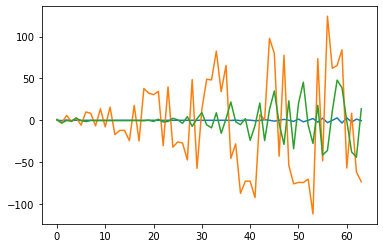

In [38]:
plt.plot(np.squeeze(km.cluster_centers_).T) 
plt.show() 

In [11]:
km_sax= TimeSeriesKMeans(n_clusters=10, metric="euclidean", 
                      max_iter=5, random_state=0)
km_sax.fit(x_train_sax)

TimeSeriesKMeans(max_iter=5, n_clusters=10, random_state=0)

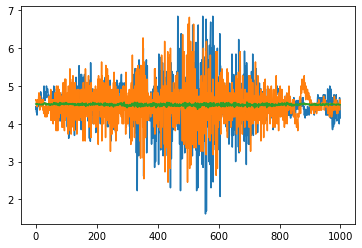

In [9]:
plt.plot(np.squeeze(km_sax.cluster_centers_).T)
plt.show()

In [12]:
km.cluster_centers_.shape

(3, 64, 1)

In [16]:
pip install fastdtw


  Created wheel for fastdtw: filename=fastdtw-0.3.4-py3-none-any.whl size=3582 sha256=b7ecbae8c34120e41a2808fd02b1b00404b747bbe3e1f8cb9f355bc9ac56e9ab
  Stored in directory: c:\users\valif\appdata\local\pip\cache\wheels\1f\a1\63\bfd0fddb5bf0b59f564872e29272cee8a2de0cd745d88fede5
Successfully built fastdtw


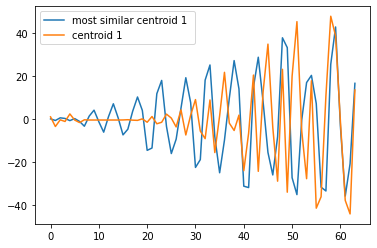

In [27]:
plt.plot(x_train_dft[249], label='most similar centroid 1 ')
plt.plot(centroids[2], label='centroid 1 ')
#plt.plot(x_train_dft[1161], label='most similar centroid 1 ')
#plt.plot(x_train_dft[249], label='most similar centroid 2 ')
plt.legend()

In [28]:
from pyts.approximation import DiscreteFourierTransform

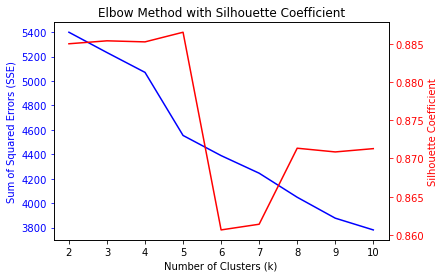

In [67]:
choose_best_k(x_train_dft,10, 'euclidean')

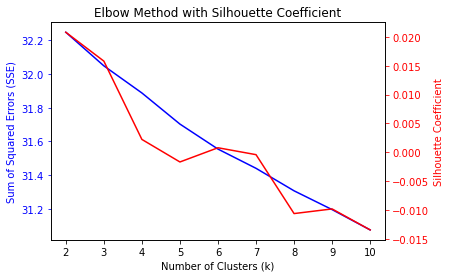

In [69]:
choose_best_k(x_train_sax,10, 'euclidean') # small sax

In [ ]:
choose_best_k(x_train_sax,10, 'dtw') # small sax

Sooooooo, let's sum up few things.
The results of clustering with DFT are:
- __Euclidean distance__:
    1. is faster and we knew that
    2. we get a slightly better silhouette, but high sse
- __DTW__:
    1. computanionally expensive
    2. we get better sse and slightly lower sil

The dtw approach seems to be the one giving us betteer results since sse halved wrt to euclidean and we only lost few points of sil. 
DTW finds more dense clusters, making few more mistakes when assigning records to their closest centroid.
Best value of k seems to be 3 or even 7. 
  

todo:
1. try to find a significant clustering among dft(dtw/euclidean) and sax (euclidean)
2. once is found compute the nearest ts for each centroid. These will be used to perform motif/anomaly discover
3. analyze the content of the cluster, look what's inside, counters, emo distributions
4. visualize the clusters with dimensionality reduction


## Best clustering with dft


In [20]:
km_best = TimeSeriesKMeans(n_clusters=3, metric='dtw', max_iter=5, random_state=0)
km_best.fit(x_train_dft)

TimeSeriesKMeans(max_iter=5, metric='dtw', random_state=0)

In [136]:
sse=km_best.inertia_
silhouette = silhouette_score(x_train_dft, km_best.labels_)

print(sse, silhouette)

1575.897133415603 0.7669232219552471


In [188]:
print(getNearestTS(x_train_dft, km_best.cluster_centers_))

Centroid 0: Nearest Time Series Index = 298
Centroid 1: Nearest Time Series Index = 1161
Centroid 2: Nearest Time Series Index = 249
None


In [139]:
inv_nearest0= inverse_dft(x_train_dft[298], x_train.shape[1])

In [ ]:
x_train.shape[1]

92672

In [ ]:
inv_nearest0.shape

(92672,)

In [ ]:
x_train[298].shape

(92672,)

In [ ]:
inv_nearest01.shape

(1828, 92672)

In [ ]:
np.min(inv_nearest0)

-5.78009280430657e-05

In [ ]:
from tslearn.preprocessing import TimeSeriesScalerMinMax

In [ ]:
original_scaled= TimeSeriesScalerMinMax(value_range= (np.min(inv_nearest0), np.max(inv_nearest0))).fit_transform(x_train_dft_inv[298].reshape(1,-1))

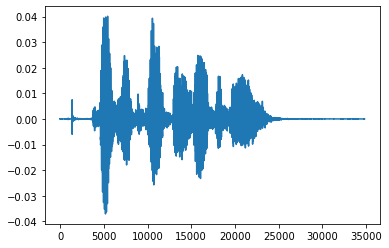

In [ ]:
'''plt.plot(inv_nearest0) # mia
plt.plot(x_train_dft_inv[298]) #spinnato
plt.plot(np.squeeze(original_scaled)) '''

plt.plot(x_train[0])

At this point:
- dft_inverse_transform works on the entire dataset, but the scale is very small. If for whatsoever reason we'd like to:
    1. visualize the nearest ts --> possible but we need to decide which is the correct scale
    2. visualize an interpretable centroid --> not possible 
    

In [21]:
cluster_labels=km_best.labels_

In [ ]:
import pandas as pd
import numpy as np

# Assuming 'time_series' is the NumPy array containing the time series data
x_train_dft_flat = x_train_dft.flatten()
# Create a DataFrame from the time series array
dft_ts_df = pd.DataFrame({'Time_Series_Value': x_train_dft_flat})

# Optionally, you can set an index for the DataFrame
dft_ts_df.index = pd.RangeIndex(len(dft_ts_df))

# Print the resulting DataFrame
print(dft_ts_df)



        Time_Series_Value
0                0.050464
1                0.028678
2               -0.038397
3               -0.013577
4               -0.038031
...                   ...
116987          -0.083057
116988          -0.214164
116989          -0.108138
116990           0.270933
116991           0.298851

[116992 rows x 1 columns]


In [ ]:
x_train_dft_reshaped = x_train_dft.reshape(1828, 64)

# Create a DataFrame from the reshaped array
dft_ts_df = pd.DataFrame(x_train_dft_reshaped)

# Optionally, you can set column names and an index for the DataFrame
dft_ts_df.columns = [f'Feature_{i}' for i in range(64)]
dft_ts_df.index = pd.RangeIndex(len(dft_ts_df))

# Print the resulting DataFrame
dft_ts_df

,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,...,Feature_54,Feature_55,Feature_56,Feature_57,Feature_58,Feature_59,Feature_60,Feature_61,Feature_62,Feature_63
0,0.050464,0.028678,-0.038397,-0.013577,-0.038031,-0.028787,-0.003135,-0.003952,0.017417,0.015444,...,-0.000157,0.005943,-0.013864,-0.012108,-0.012197,-0.014594,0.006203,-0.000024,0.010836,0.003733
1,0.039203,0.019877,-0.027883,-0.006944,-0.020751,-0.007518,-0.002436,0.002323,-0.001037,0.001765,...,-0.017900,-0.014698,-0.006436,-0.011051,0.002328,-0.006296,0.005078,-0.002481,0.005277,-0.001427
2,0.049228,0.000992,-0.045496,-0.036134,0.003490,0.010866,0.023796,0.008781,-0.013943,-0.010386,...,0.006790,0.000696,0.007434,0.008497,0.003737,0.002932,-0.007731,-0.006008,-0.000411,-0.001919
3,0.047775,0.040187,-0.023818,0.018227,-0.038090,-0.007283,-0.031589,-0.015563,-0.008981,-0.001523,...,0.005163,0.002755,0.003206,0.004095,-0.000320,0.002235,-0.005241,-0.003838,-0.007266,-0.009248
4,0.045884,-0.019110,-0.028423,-0.002549,0.014954,0.000499,-0.003779,-0.000416,0.011639,0.019157,...,0.000877,-0.010199,-0.007325,0.002873,0.015745,0.008850,-0.012304,-0.007381,0.000707,0.001869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1823,-0.051169,-0.026526,0.036526,0.009233,0.028104,0.010451,0.003597,-0.001071,0.002821,0.004560,...,-0.012555,-0.014340,-0.021721,-0.032340,-0.002625,-0.021070,0.020833,-0.000699,0.019162,0.001527
1824,-0.047830,0.043180,0.039747,0.017704,-0.068591,-0.065458,0.011938,0.039536,0.035322,-0.008258,...,-0.158465,-0.190866,0.178810,0.229034,0.214731,0.230413,-0.274459,-0.306298,-0.237188,-0.233178
1825,-0.069978,-0.028463,0.065015,0.047236,0.054041,0.065551,-0.017654,0.008858,-0.055816,-0.036340,...,-0.205275,-0.104621,-0.220979,-0.236578,-0.135556,-0.307957,0.008640,-0.306476,0.197249,-0.172029
1826,-0.030572,0.009666,0.026191,0.016160,-0.012732,-0.010038,-0.008271,-0.009569,0.006944,0.006334,...,-0.005590,-0.012054,-0.002131,0.006488,0.017322,0.020838,-0.014664,-0.016518,-0.019065,-0.012346


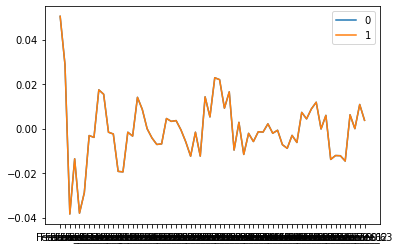

In [ ]:
plt.plot(dft_ts_df.iloc[0], label='0')
plt.plot(x_train_dft[0], label='1')
plt.legend()

In [183]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [185]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,5)
plt.style.use("_classic_test_patch")


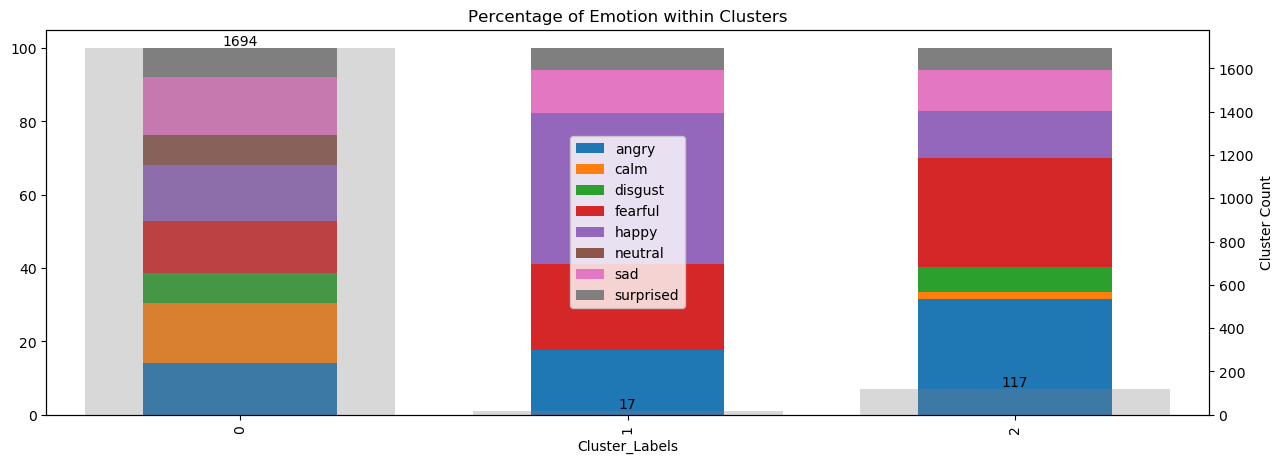

In [193]:

# Assuming 'cluster_labels' is the NumPy array or pandas Series containing the cluster labels
# Assuming 'y_train' is the DataFrame containing the 'emotion' attribute

# Add the cluster labels to the emotion DataFrame
y_train['Cluster_Labels'] = cluster_labels

# Calculate the percentage of each emotion within each cluster
grouped_data = y_train.groupby(['Cluster_Labels', 'emotion']).size()
cluster_totals = grouped_data.groupby('Cluster_Labels').sum()
percentages = grouped_data.div(cluster_totals, level='Cluster_Labels') * 100

# Reset the index and pivot the DataFrame to have emotions as columns
pivot_df = percentages.reset_index().pivot(index='Cluster_Labels', columns='emotion', values=0)

# Plot the bar chart for each cluster
cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
ax = pivot_df.plot(kind='bar', stacked=True)

# Plot the cluster counts as a separate bar plot
ax2 = ax.twinx()
ax2.bar(cluster_counts.index, cluster_counts.values, alpha=0.3, color='gray')

# Add labels and title to the plot
plt.xlabel('Cluster')
plt.ylabel('Percentage')
plt.title('Percentage of Emotion within Clusters')
ax2.set_ylabel('Cluster Count')

# Annotate each bar with the cluster count
for i, v in enumerate(cluster_counts.values):
    ax2.text(i, v, str(v), ha='center', va='bottom')

# Show the legend
ax.legend()

# Display the plot
plt.show()


## best clustering with sax

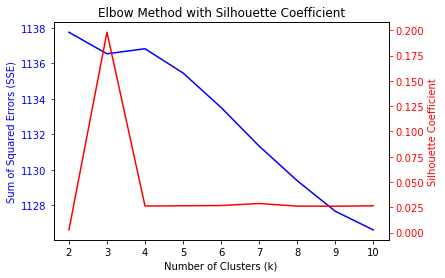

In [70]:
choose_best_k(x_train_sax_big,10, 'euclidean')

In [ ]:
choose_best_k(x_train_sax_big,10, 'euclidean')

In [49]:
x_train_sax.shape

(1828, 100)

2th fit done
2th append done
3th fit done
3th append done
4th fit done
4th append done
5th fit done
5th append done
6th fit done
6th append done
7th fit done
7th append done
8th fit done
8th append done
9th fit done
9th append done
10th fit done
10th append done


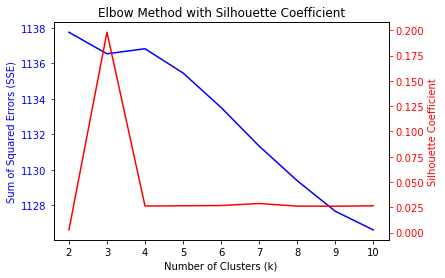

In [57]:
max_k=10
sse = []
silhouette_scores = []

for k in range(2, max_k+1):
    kmeans = TimeSeriesKMeans(n_clusters=k, max_iter=5, random_state=0, metric='euclidean')
    kmeans.fit(x_train_sax_big)
    sse.append(kmeans.inertia_)
    print(f'{k}th fit done')
    
    # Calculate silhouette coefficient
    labels = kmeans.labels_
    silhouette = silhouette_score(x_train_sax_big, labels, metric='euclidean')
    silhouette_scores.append(silhouette)
    print(f'{k}th append done')


# Plot SSE and silhouette scores
fig, ax1 = plt.subplots()
ax1.plot(range(2, max_k + 1), sse, 'b-')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Sum of Squared Errors (SSE)', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(range(2, max_k + 1), silhouette_scores, 'r-')
ax2.set_ylabel('Silhouette Coefficient', color='r')
ax2.tick_params('y', colors='r')

plt.title('Elbow Method with Silhouette Coefficient')
plt.show()



In [ ]:
km_sax= TimeSeriesKMeans(n_clusters=3, metric="dtw", 
                      max_iter=5, random_state=0)
km_sax.fit(x_train_sax_big)
labels_sax=km_sax.labels_
c_counts_sax = pd.Series(labels_sax).value_counts().sort_index()
c_counts_sax

## dimensionality reduction

### t-sne

In [26]:
from sklearn.manifold import TSNE

In [27]:
tsne = TSNE(n_components=2)
X_train_dft_tsne = tsne.fit_transform(x_train_dft)
X_train_dft_tsne.shape


c:\Users\valif\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\valif\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(1828, 2)

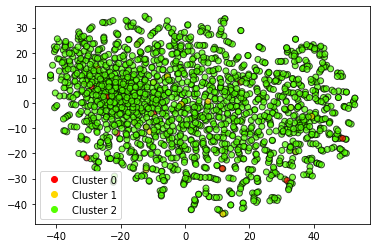

In [29]:


# Your code for scatter plot here
plt.scatter(X_train_dft_tsne[:, 0], X_train_dft_tsne[:, 1], c=labels_sax, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)

# Assuming labels_sax is a list/array containing the cluster labels for each data point

# Create a list of unique cluster labels
unique_labels = list(set(labels_sax))

# Assign a color for each cluster label
colors = plt.cm.prism(np.linspace(0, 1, len(unique_labels)))

# Create a legend entry for each cluster label
legend_entries = []
for label, color in zip(unique_labels, colors):
    legend_entries.append(plt.Line2D([], [], marker='o', linestyle='', color=color, label=f'Cluster {label}'))

# Add the legend with the created entries
plt.legend(handles=legend_entries)

plt.show()



### PCA


In [24]:
from sklearn.decomposition import PCA

In [25]:
pca = PCA(n_components=2)
pca.fit(x_train_dft)
X_train_dft_pca = pca.transform(x_train_dft)
X_train_dft_pca.shape

(1828, 2)

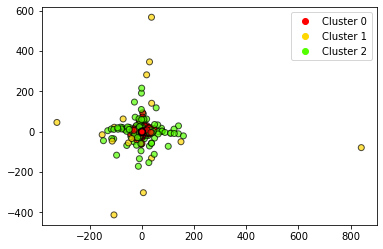

In [28]:

# Your code for scatter plot here
plt.scatter(X_train_dft_pca[:, 0], X_train_dft_pca[:, 1], c=cluster_labels, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)

# Assuming cluster_labels is a list/array containing the cluster labels for each data point

# Create a list of unique cluster labels
unique_labels = list(set(cluster_labels))

# Assign a color for each cluster label
colors = plt.cm.prism(np.linspace(0, 1, len(unique_labels)))

# Create a legend entry for each cluster label
legend_entries = []
for label, color in zip(unique_labels, colors):
    legend_entries.append(plt.Line2D([], [], marker='o', linestyle='', color=color, label=f'Cluster {label}'))

# Add the legend with the created entries
plt.legend(handles=legend_entries)

plt.show()


### IsoMap

In [43]:
from sklearn.manifold import Isomap

In [44]:
iso = Isomap(n_components=2)
X_train_sax_iso = iso.fit_transform(x_train_sax)
X_train_sax_iso.shape

(1828, 2)

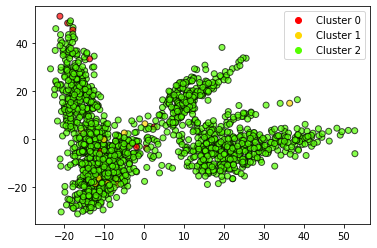

In [45]:
plt.scatter(X_train_sax_iso[:, 0], X_train_sax_iso[:, 1], c=labels_sax, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)

# Create a list of unique cluster labels
unique_labels = list(set(labels_sax))

# Assign a color for each cluster label
colors = plt.cm.prism(np.linspace(0, 1, len(unique_labels)))

# Create a legend entry for each cluster label
legend_entries = []
for label, color in zip(unique_labels, colors):
    legend_entries.append(plt.Line2D([], [], marker='o', linestyle='', color=color, label=f'Cluster {label}'))

# Add the legend with the created entries
plt.legend(handles=legend_entries)

plt.show()
